# Getting more data
https://groundhog-day.com/api

In [291]:
import requests
import json
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [319]:
resp = requests.get('https://groundhog-day.com/api/v1/groundhogs')
hogs = pd.DataFrame(resp.json()['groundhogs'])
#hogs = hogs.drop(['predictions'], axis=1)
hogs['longitude'] = pd.to_numeric(hogs['coordinates'].str.split(',').str[1])
hogs['latitude'] = pd.to_numeric(hogs['coordinates'].str.split(',').str[0])

hogs.to_csv('prognosticators.csv', index=False)

In [217]:
hogs['isGroundhog'].value_counts()

isGroundhog
0    43
1    32
Name: count, dtype: int64

In [322]:
map = folium.Map(location=[hogs['latitude'].mean(), 
                           hogs['longitude'].mean()], 
                 zoom_start=4)

for _, row in hogs.query('isGroundhog==1').iterrows():
    folium.Marker(location=[row['latitude'], 
                            row['longitude']] , 
                  popup=row['name'], icon=folium.Icon(color="green")).add_to(map)
    
for _, row in hogs.query('isGroundhog==0').iterrows():
    folium.Marker(location=[row['latitude'], 
                            row['longitude']] , 
                  popup=row['name'], icon=folium.Icon(color="red")).add_to(map)

In [323]:
map

# Explore the prognosticators

<Axes: title={'center': 'Count by prognosticator type'}, ylabel='type'>

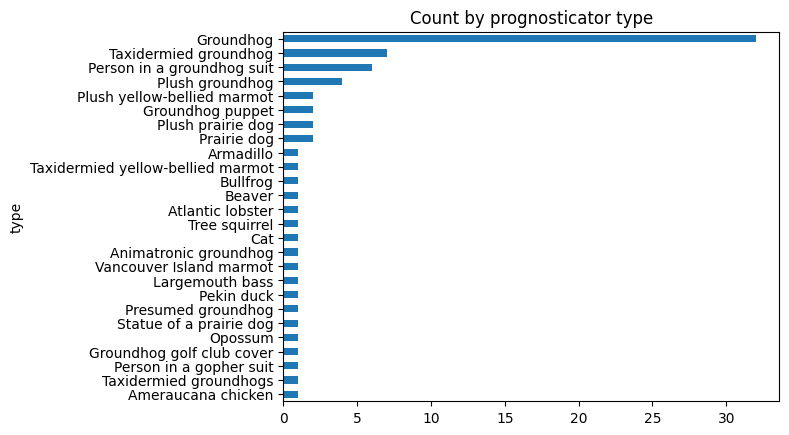

In [221]:
hogs['type'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Count by prognosticator type')

# Explode out predictions from each prognosticator

In [222]:
progs = pd.DataFrame(resp.json()['groundhogs'])


In [223]:
dfs = []
for i, d in progs.iterrows():
    df = pd.DataFrame(d['predictions'])
    df = df.assign(**d[['id', 'slug']].to_dict())[['id', 'slug', 'year', 'shadow', 'details']] # ** turns dict into function arguments
    #df.to_csv(f'{d["slug"]}.csv', index=False)
    dfs.append(df) # create list of dataframes


In [224]:
df_all = pd.concat(dfs).reset_index(drop=True).copy()

In [225]:
df_all['slug'].value_counts()

slug
punxsutawney-phil       139
octoraro-orphie          99
wiarton-willie           70
jimmy-the-groundhog      56
concord-charlie          46
                       ... 
lady-edwina-of-essex      3
okanagan-okie             3
pisgah-penny              3
queen-city-charlie        3
unadilla-billie           3
Name: count, Length: 75, dtype: int64

<Axes: title={'center': 'Number of predictions'}, ylabel='slug'>

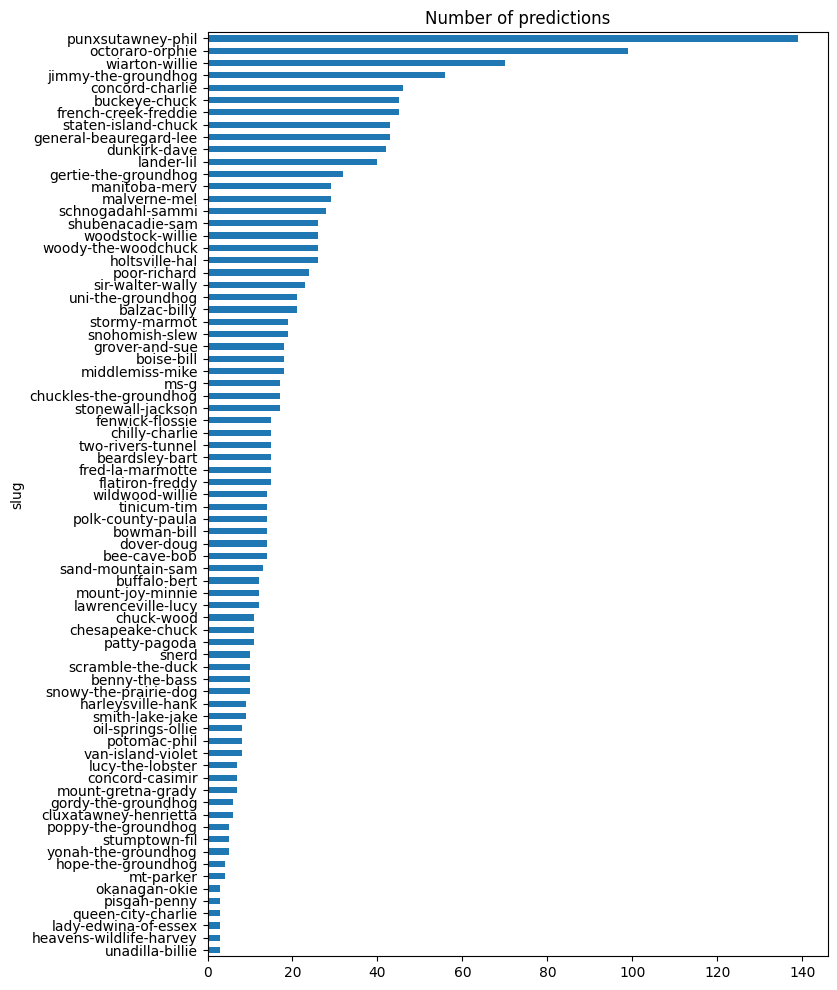

In [226]:


df_all['slug'].value_counts().sort_values(ascending=True)\
    .plot(kind='barh', figsize=(8,12), title='Number of predictions')

In [227]:
good_progs = df_all['slug'].value_counts().to_frame().query('count > 20').index.to_list()

In [228]:
raw_preds = df_all.query('slug in @good_progs').groupby(['slug', 'year'])['shadow'].first().unstack().T

<Axes: xlabel='year', ylabel='slug'>

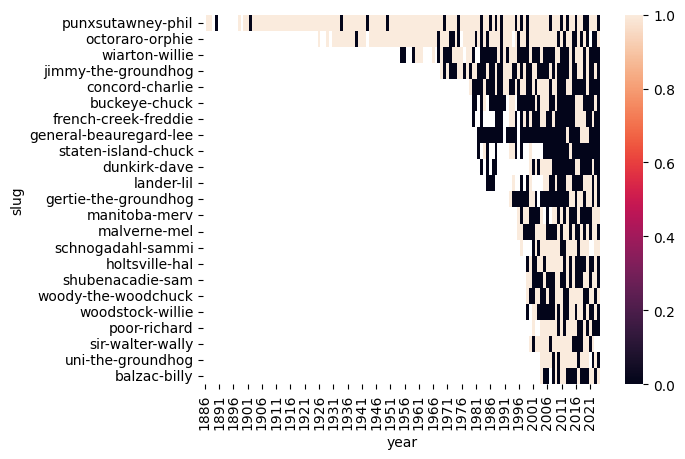

In [229]:
sns.heatmap(raw_preds[good_progs].T)

# Pull History Weather
Using Long/Lat

In [232]:
def get_weather_forecast(latitude, longitude):
    url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&daily=temperature_2m_max,temperature_2m_min,precipitation_sum"
    
    response=requests.get(url)
    if response.status_code == 200:
        forecast_data = response.json()
        return forecast_data['daily']
    else:
        print("Failed to retrieve data:", response.status_code)
        return None
    
for i, d in hogs.iterrows():
    latitude = d['latitude']
    longitude = d['longitude']
    
    forecast = get_weather_forecast(latitude, longitude)
    if forecast:
        print(forecast)
    break

{'time': ['2024-02-03', '2024-02-04', '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09'], 'temperature_2m_max': [-34.4, -39.9, -41.6, -44.1, -46.8, -47.5, -34.4], 'temperature_2m_min': [-40.3, -42.0, -43.9, -46.4, -49.2, -50.4, -48.1], 'precipitation_sum': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6]}


In [314]:
def get_historical_weather(latitude, longitude, start_date, end_date, daily_codes):
    url = f"https://archive-api.open-meteo.com/v1/era5?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily={daily_codes}"
           
    response=requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to retrieve data:", response.status_code)
        return None

latitude = 52.52
longitude= 13.41
start_date="2021-01-01"
end_date="2021-12-31"

daily_codes = ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max", 
               "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", 
               "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", 
               "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", 
               "shortwave_radiation_sum", "et0_fao_evapotranspiration"]



weather_data = get_historical_weather(latitude, longitude, start_date, end_date, ','.join(daily_codes))

In [324]:
all_weather = []

for i, d in hogs.iterrows():
    pred_years = pd.DataFrame(d['predictions']).dropna(subset=['shadow'])
    for year in pred_years['year'].values:
        time.sleep(1)
        print(f"Pulling for {d['slug']} - Year {year}")
        latitude = d['latitude']
        longitude = d['longitude']
        start_date = f'{year}-01-01'
        end_date = f'{year}-04-01'
        weather_data = get_historical_weather(latitude, longitude, start_date, end_date, ','.join(daily_codes))
        if weather_data is None:
            #print('No weather')
            pass
        else:
            weather_df = pd.DataFrame(weather_data['daily']).assign(slug=d['slug'], year=year)
            all_weather.append(weather_df)

all_weather_df = pd.concat(all_weather)
all_weather_df.to_csv('historic_weather.csv', index=False)

Pulling for punxsutawney-phil - Year 1887
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1888
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1890
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1898
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1900
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1901
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1902
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1903
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1904
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1905
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1906
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1907
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1908
Failed to retrieve data: 400
Pulling for punxsutawney-phil - Year 1909
Failed to retrieve data: 400
Pullin

KeyboardInterrupt: 

In [325]:
all_weather_df = pd.concat(all_weather)
all_weather_df.to_csv('historic_weather.csv', index=False)

In [326]:
all_weather_df

,time,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,slug,year
0,1940-01-01,2,-9.3,-17.3,-13.5,-14.9,-23.3,-19.4,1940-01-01T12:40,1940-01-01T21:58,...,NaN,NaN,0.0,18.3,NaN,252,NaN,NaN,punxsutawney-phil,1940
1,1940-01-02,71,-7.8,-13.4,-11.5,-13.5,-19.4,-17.6,1940-01-02T12:40,1940-01-02T21:59,...,0.0,0.56,8.0,19.6,43.6,257,6.58,0.38,punxsutawney-phil,1940
2,1940-01-03,71,-8.6,-16.0,-12.0,-13.7,-21.8,-17.7,1940-01-03T12:40,1940-01-03T21:59,...,0.0,0.28,4.0,17.6,38.2,257,7.73,0.39,punxsutawney-phil,1940
3,1940-01-04,3,-7.9,-17.8,-13.0,-12.5,-22.9,-18.0,1940-01-04T12:40,1940-01-04T22:00,...,0.0,0.00,0.0,14.8,31.0,238,7.99,0.46,punxsutawney-phil,1940
4,1940-01-05,73,-3.5,-12.3,-7.0,-8.7,-18.6,-12.1,1940-01-05T12:40,1940-01-05T22:01,...,0.0,1.96,15.0,22.7,51.5,230,5.21,0.41,punxsutawney-phil,1940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2000-03-28,55,10.1,-2.0,4.1,7.6,-4.9,1.3,2000-03-28T11:04,2000-03-28T23:36,...,3.4,0.00,6.0,13.9,35.6,287,17.02,1.97,punxsutawney-phil,2000
88,2000-03-29,71,6.4,0.1,3.2,1.9,-4.5,-1.9,2000-03-29T11:03,2000-03-29T23:37,...,1.7,0.07,7.0,28.9,64.8,268,9.25,1.17,punxsutawney-phil,2000
89,2000-03-30,3,7.5,1.7,4.1,3.5,-1.8,0.2,2000-03-30T11:01,2000-03-30T23:38,...,0.0,0.00,0.0,13.6,35.3,286,15.05,1.92,punxsutawney-phil,2000
90,2000-03-31,0,11.5,-2.8,3.6,8.3,-6.4,0.0,2000-03-31T10:59,2000-03-31T23:39,...,0.0,0.00,0.0,13.4,35.3,312,23.48,2.96,punxsutawney-phil,2000


In [332]:
all_weather_df['shadow'] = all_weather_df['year'].map(df_all.query('slug == "punxsutawney-phil"').set_index('year')['shadow'])

<Axes: xlabel='shadow', ylabel='temperature_2m_mean'>

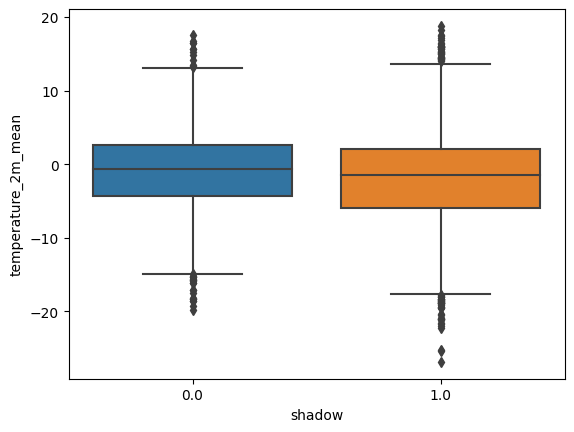

In [333]:
sns.boxplot(all_weather_df, x='shadow', y='temperature_2m_mean')

In [334]:
all_weather_df['month']=pd.to_datetime(all_weather_df['time']).dt.month

<Axes: xlabel='shadow', ylabel='temperature_2m_mean'>

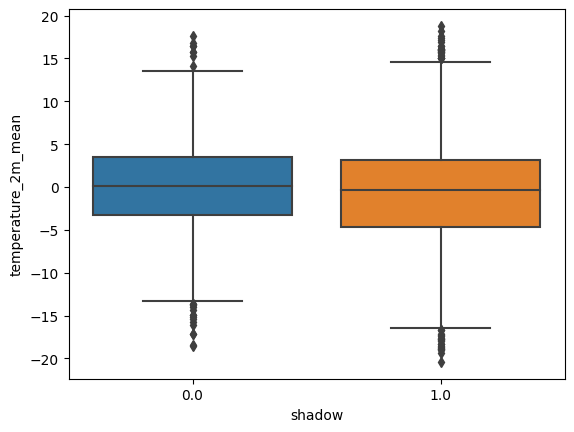

In [335]:
sns.boxplot(all_weather_df.query('month >= 2'), x='shadow', y='temperature_2m_mean')

When the groundhog sees his shadow (shadow==1) the winter is supposed to stay longer

In [341]:
all_weather_df.query('month >= 2').groupby(['shadow'])['temperature_2m_mean'].mean()

shadow
0.0   -0.041604
1.0   -0.673599
Name: temperature_2m_mean, dtype: float64

In [346]:
avg_temp_by_year = all_weather_df.query('month >= 2').groupby(['year', 'shadow'])['temperature_2m_mean'].mean().reset_index()

<Axes: xlabel='shadow', ylabel='temperature_2m_mean'>

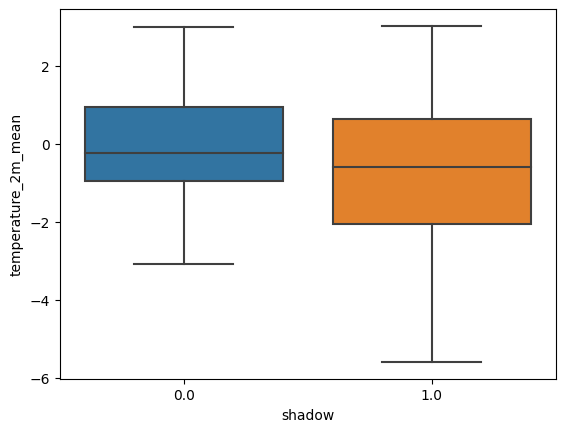

In [347]:
sns.boxplot(avg_temp_by_year, x='shadow', y='temperature_2m_mean')

In [351]:
total_snowfall_by_year = all_weather_df.query('month >= 2').groupby(['year', 'shadow'])['snowfall_sum'].sum().reset_index()

<Axes: xlabel='shadow', ylabel='snowfall_sum'>

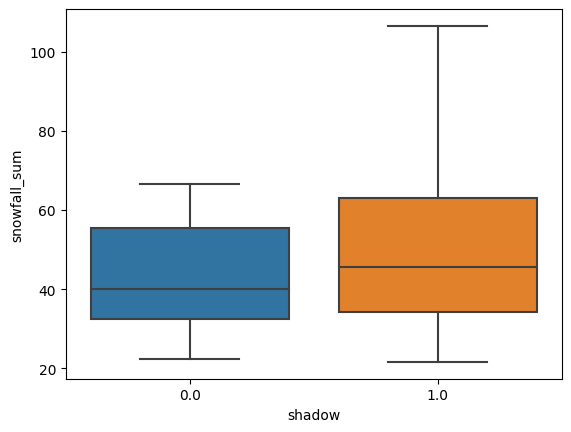

In [353]:
sns.boxplot(total_snowfall_by_year, x='shadow', y='snowfall_sum')

In [354]:
shadow_map = {0: 'Early spring',
              1: 'Long winter'}


all_weather_df['prediction'] = all_weather_df['shadow'].map(shadow_map)

In [355]:
total_snowfall_by_year = all_weather_df.query('month >= 2').groupby(['year', 'prediction'])['snowfall_sum'].sum().reset_index()

<Axes: xlabel='prediction', ylabel='snowfall_sum'>

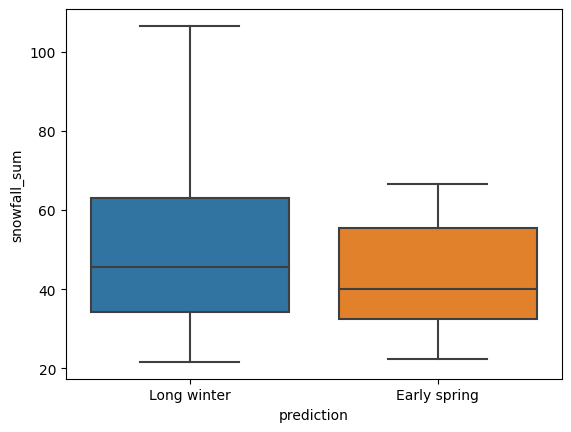

In [356]:
sns.boxplot(total_snowfall_by_year, x='prediction', y='snowfall_sum')